##  Transfer Learning Using Supervised Pretraining

- Flowers dataset https://www.kaggle.com/datasets/alxmamaev/flowers-recognition


Mounting Google drive to Colab.
Only the directory path will be changed according to directory path in Google Drive

In [4]:
! ls
%cd /content/drive/MyDrive/Colab Notebooks/LinkedIn Learning/07_Self-Supervised Machine Learning

drive  sample_data
/content/drive/MyDrive/Colab Notebooks/LinkedIn Learning/07_Self-Supervised Machine Learning


In [5]:
!ls

 datasets
'datasets (1)'
 datasets.zip
 demo_01_TransferLearningWithSupervisedPretraining.ipynb
 demo_02_TransferLearningWithSelfSupervisedSimCLRPretraining.ipynb
 demo_03_TransferLearningWithSelfSupervisedSwAVPretraining.ipynb
 __MACOSX
 Untitled0.ipynb


In [3]:
# Mount the drive

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Installing required libraries and modules

In [6]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 17.3 MB/s eta 0:00:00


In [7]:
!pip install lightning-bolts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.1.2
    Uninstalling pytorch-lightning-2.1.2:
      Successfully uninstalled pytorch-lightning-2.1.2


In [8]:
pip install git+https://github.com/PytorchLightning/lightning-bolts.git@master --upgrade

  Cloning https://github.com/PytorchLightning/lightning-bolts.git (to revision master) to /tmp/pip-req-build-03rqlwjv
  Running command git clone --filter=blob:none --quiet https://github.com/PytorchLightning/lightning-bolts.git /tmp/pip-req-build-03rqlwjv
  Resolved https://github.com/PytorchLightning/lightning-bolts.git to commit 239e527968e1e0071ac2e287ad25056dc8ac88df
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [9]:
! pip install torchmetrics

Importing required libraries

In [10]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt

import os
import torch
import pl_bolts
import torchvision
import torchmetrics
import pytorch_lightning as pl

from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy

from torchvision import models
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

Point the data_dir to where your flowers dataset is loaded in Google Drive

Original images are not square and all of different sizes

In [11]:
# Load the directory
data_dir = '/content/drive/MyDrive/Colab Notebooks/LinkedIn Learning/07_Self-Supervised Machine Learning/datasets/flower/flowers'

os.listdir(data_dir)

['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']

First of all images need to be of same size (resized to 224 x 224) and to be converted to Tensor form and normalized.

- Pre-trained models in Pytorch expect images to be at least 224 x 224 in size
- Images are also normalized using the mean and standard deviation of the Imagenet dataset which comprises of millions of images
- If you know the mean and standard deviation of your own image dataset you can use that to normalize images

In [12]:
# Preprocess the data
basic_transformer = torchvision.transforms.Compose(
    [
     # Resize the image as 224 x 224
     torchvision.transforms.Resize((224, 224)),
     # Covert the images as Tensor Representation
     torchvision.transforms.ToTensor(),
     # Normalize the representation using the mean and Standard deviation values taken from ImageNet
     torchvision.transforms.Normalize(
         mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
     ),
    ]
)

# Reading the dataset from a folder
flower_dataset = ImageFolder(data_dir, transform = basic_transformer)

# Check out the length of the dataset
len(flower_dataset)

4337

In [13]:
flower_dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [15]:
def show_img_example(img, label):
    print('Label: ', flower_dataset.classes[label], "(" + str(label) + ")")
    # Pytorch loads images with
      # number of channel as 1st dimension
      # Height and width as 2nd and 3rd dimension
    plt.imshow(img.permute(1, 2, 0))

A single Flower image (unaugmented)

Label:  daisy (0)


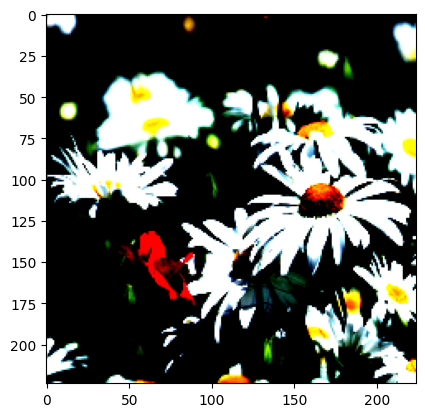

In [17]:
show_img_example(*flower_dataset[5]) # here we mentioned index number

Label:  sunflower (3)


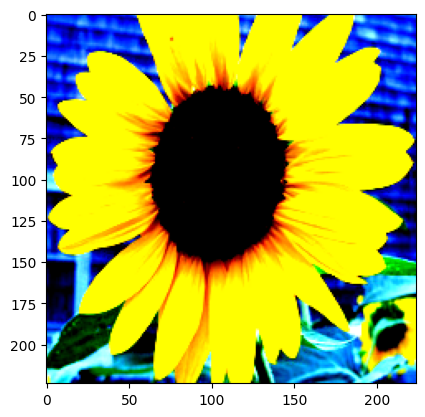

In [18]:
show_img_example(*flower_dataset[3005]) # here we mentioned index number

Data module inherited from LightningDataModule:

A collection of a train_dataloaders, val_dataloaders, test_dataloaders along with the matching transforms and data processing/downloads steps required.

To define a DataModule define 5 methods:

1.prepare_data (how to download(), tokenize, etc…) (not implemented in this case)

2.setup (how to split, etc…)

3.train_dataloader

4.val_dataloader(s)

5.test_dataloader(s) (Not implemented in this case)

Agument the data to increase the number of samples used to fine-tune the pre-trained model on our data

Link for reference:

https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html#what-is-a-datamodule

In [20]:
# We use this data module using the lightening data module
# It is similar to Tensorflow Dataset
class FlowerDataModule(pl.LightningDataModule):
    # Initialize the datamodule class
    def __init__(self, data_dir =  '/content/drive/MyDrive/Colab Notebooks/LinkedIn Learning/07_Self-Supervised Machine Learning/datasets/flower/flowers'):
        super().__init__()

        self.data_dir = data_dir
        # Specify the transforms
        self.transform = transforms.Compose(
          [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p = 0.1),
            transforms.RandomRotation(10),
              transforms.ToTensor(),
              transforms.Normalize(
                  mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
              ),
          ]
        )
    # Setup function to training and validation dataset
    def setup(self, stage= None):
        # Points the image directory and apply the required transformation
        flower_full = ImageFolder(self.data_dir, transform = self.transform)

        length = len(flower_full) # Consider entire length of the images

        val_split_size = 0.2 # use 20% for validation dataset

        train_length = round(length * (1 - val_split_size)) # set number for training
        val_length = length - train_length # number for validation

        # split the data using the random split
        self.flower_train, self.flower_val = random_split(flower_full , [train_length, val_length])

    def train_dataloader(self): # defining the training dataloader
        train_dataloader = DataLoader(self.flower_train, batch_size = 32, shuffle = True)

        return train_dataloader

    def val_dataloader(self):  # defining the Validation dataloader
        # Validaton and test data usually not shuffled
        val_dataloader = DataLoader(self.flower_val, batch_size = 32)

        return val_dataloader


Flower Data module is instantiated and setup is called

In [21]:
flower_dm = FlowerDataModule()

flower_dm.setup()

Training and validation dataloaders are obtained and dimensions are checked. Note that len(dataloader) gives no. of batches as Dataloader loads images in batch form.

In [23]:
train_dl = flower_dm.train_dataloader()

# Train data has 109 batches
len(train_dl)

109

In [24]:
valid_dl = flower_dm.val_dataloader()

# Validation data has 28 batches
len(valid_dl)

28

In [25]:
# Check out the shape of the input and shape of the labels
for inp, label in train_dl:
    print('{}:{}'.format(inp, label))
    print('Input shape: ',inp.shape)
    print('Labels shape: ', label.shape)
    break

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [ ]:
# The above result dimension shows
# batch size --> 32
# Dimension --> 3 channel
# size --> 224 x 224

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


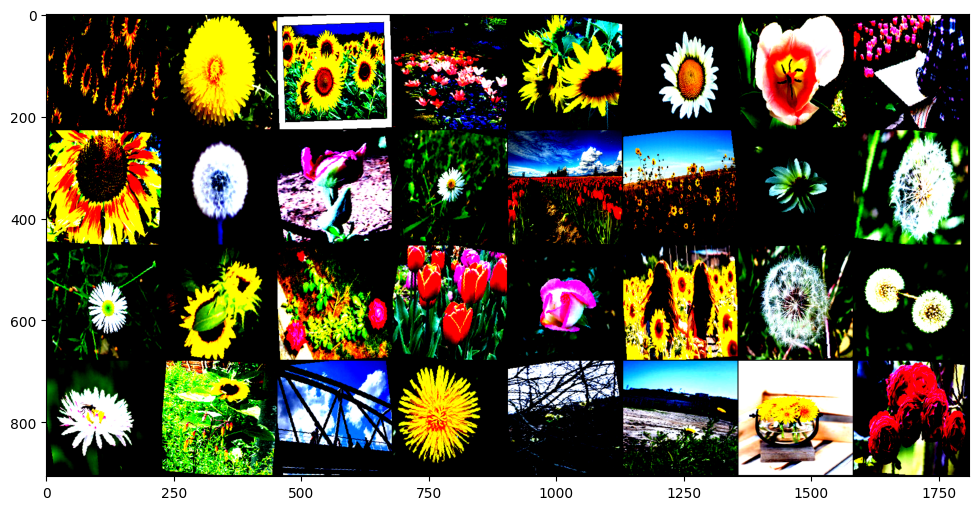

In [26]:
# for viewing all of the images in a single batch
def show_batch_images(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12, 6))
        ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break

show_batch_images(train_dl)

One random augmented Individual image is visualised

## Supervised Pretraining

### Fitting only the new finetuning layer

Defining the FlowerImageClassifier using Pytorch lightning.

A LightningModule organizes your PyTorch setup, training, validation etc. code into 5 functions and calls the functions at the right time during the training process.

Computations (init).

Train loop (training_step)

Validation loop (validation_step)

Test loop (test_step)

Optimizers (configure_optimizers).
Hyperparameters are set

Num of classes of flower(num_classes = 5)
Learning rate(lr) = 1e-3

Here we freeze the pretrained model throughout the training process. Only the last layer, the linear classifier is fine-tuned during training.


Links for reference:
https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html

In [ ]:
class FlowerImageClassifier(pl.LightningModule):
    def __init__(self, num_classes = 5, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.backbone = models.resnet50(pretrained = True)

        self.finetune_layer = torch.nn.Linear(self.backbone.fc.out_features, num_classes)


    def training_step(self, batch, batch_idx):

        x, y = batch

        with torch.no_grad():
            features = self.backbone(x)

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y)

        metrics = {'train_loss': loss, 'train_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True,
                      prog_bar = True, logger = True)

        return loss

    def validation_step(self, batch, batch_idx):

        x, y = batch

        features = self.backbone(x)
        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y)

        metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True,
                      prog_bar = True, logger = True)

        return metrics

    def configure_optimizers(self):

        optimizer = Adam(self.parameters(), lr = self.hparams.lr)

        return optimizer

CSV Logger is defined to log the metrics into a csv file

In [ ]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'resnet50_bb_frozen')

In [ ]:
# classifier = FlowerImageClassifier()

# trainer = pl.Trainer(max_epochs = 20, logger = logger, gpus = 1)
# trainer.fit(classifier, flower_dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type   | Params
------------------------------------------
0 | backbone       | ResNet | 25.6 M
1 | finetune_layer | Linear | 5.0 K 
------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.248   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
classifier = FlowerImageClassifier()

trainer = pl.Trainer(max_epochs = 20,
                     limit_train_batches = 20,
                     log_every_n_steps = 10,
                     logger = logger, gpus = 1)

trainer.fit(classifier, flower_dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type   | Params
------------------------------------------
0 | backbone       | ResNet | 25.6 M
1 | finetune_layer | Linear | 5.0 K 
------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.248   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

We can also limit our no. of  train batches examples  using limit_train_batches.Then we need to adjust the log every n steps to some smaller value(as default is 50). It increases the speed of training

Metrics logged in CSV file are now plotted.

In [ ]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

metrics.head()

,valid_loss,valid_acc,epoch,step,train_loss,train_acc
0,0.756121,0.725490,0,19,NaN,NaN
1,NaN,NaN,0,19,1.021594,0.587500
2,0.593926,0.773933,1,39,NaN,NaN
3,NaN,NaN,1,39,0.629478,0.770312
4,0.568617,0.795848,2,59,NaN,NaN


The metrics df is cleaned to obtain individual metrics in Pandas series objects form

In [ ]:
train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
train_acc = metrics['train_acc'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)
valid_acc = metrics['valid_acc'].dropna().reset_index(drop = True)

Accuracy vs Epoch plot is drawn

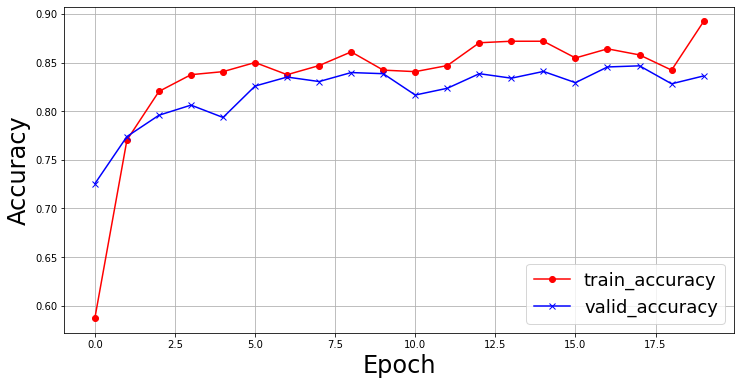

In [ ]:
fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_acc, color = 'r', marker = 'o', label = 'train_accuracy')
plt.plot(valid_acc, color = 'b', marker = 'x', label = 'valid_accuracy')

plt.ylabel('Accuracy', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'lower right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/acc_sup1.png')

Loss vs Epoch plot is shown

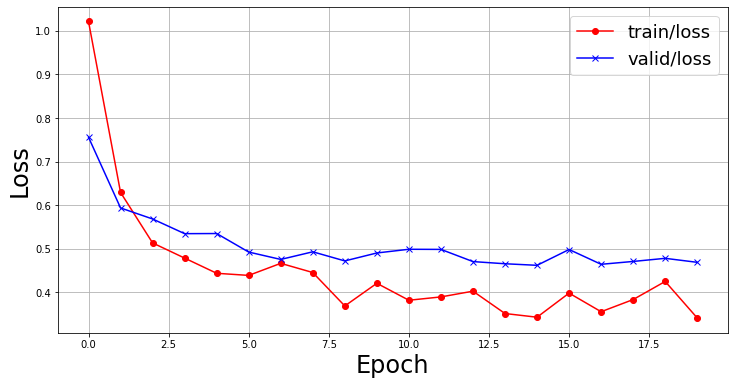

In [ ]:
fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_sup1.png')\

Note that here we are unfreezing our backbone after 10 epochs.Model's backbone is frozen for initial 10 epochs.Note that learning rate is 1e-3

In [ ]:
class FlowerImageClassifier(pl.LightningModule):
    def __init__(self, num_classes = 5, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.backbone = models.resnet50(pretrained = True)
        self.finetune_layer = torch.nn.Linear(self.backbone.fc.out_features, num_classes)

    def training_step(self, batch, batch_idx):
        x, y = batch
        if self.trainer.current_epoch < 10:
            with torch.no_grad():
                features = self.backbone(x)
        else:
             features = self.backbone(x)

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y)

        metrics = {'train_loss': loss, 'train_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True,
                      prog_bar = True, logger = True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        features = self.backbone(x)
        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y)

        metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True,
                      prog_bar = True, logger = True)

        return metrics

    def configure_optimizers(self):

        optimizer = Adam(self.parameters(), lr = self.hparams.lr)

        return optimizer

In [ ]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'resnet50_bb_unfrozen')

Classifier is called and Trainer is defined and fit with Flower Datamodule.
Training is done for 20 epochs and logger is used for logging metrics.Note that if learning rate is set 1e-4 then spike in loss is not observed while model is unfrozen.Instead it goes down and performance is quite better than when lr is 1e-3.

In [ ]:
# classifier = FlowerImageClassifier()

# trainer = pl.Trainer( max_epochs = 20,
#                      logger = logger, gpus = 1)
# trainer.fit(classifier, flower_dm)

In [ ]:
classifier = FlowerImageClassifier()

trainer = pl.Trainer(limit_train_batches = 20, max_epochs = 20, log_every_n_steps = 10,
                     logger = logger, gpus = 1)

trainer.fit(classifier, flower_dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/resnet50_bb_unfrozen
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type   | Params
------------------------------------------
0 | backbone       | ResNet | 25.6 M
1 | finetune_layer | Linear | 5.0 K 
------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.248   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metrics logged in CSV file are now plotted.

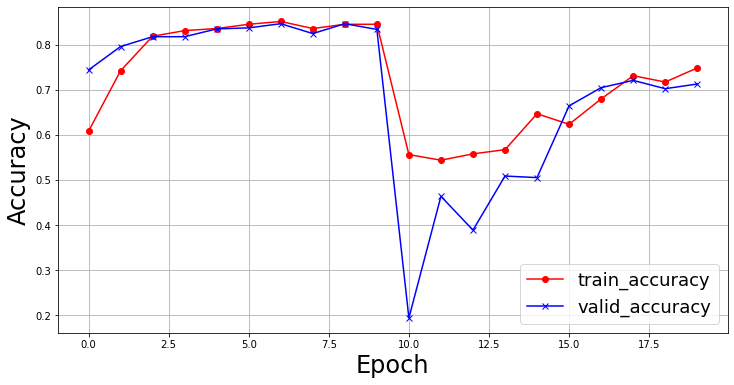

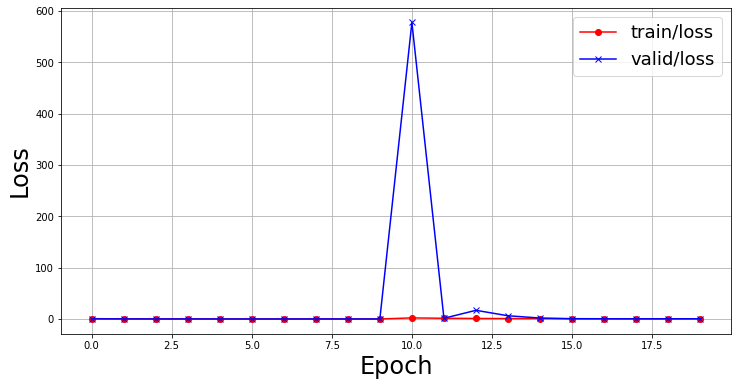

In [ ]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
train_acc = metrics['train_acc'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)
valid_acc = metrics['valid_acc'].dropna().reset_index(drop = True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_acc, color = 'r', marker = 'o', label = 'train_accuracy')
plt.plot(valid_acc, color = 'b', marker = 'x', label = 'valid_accuracy')

plt.ylabel('Accuracy', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'lower right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/acc_sup2.png')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_sup2.png')\

![](img/20201117-1-train_acc.svg "Train Accuracy")

![](img/20201117-1-train_loss.svg "Train Loss")